In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
# 오늘은 분류 문제와 달리 라벨이 필요 없어서 y_train, y_test는 생략한다.

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _), (test_x, _) = fashion_mnist.load_data()

## Data preprocess

Fashion MNIST는 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정수값을 갖는다.

In [4]:
print('max pixel : ', train_x.max())
print('min pixel : ', train_x.min())

max pixel :  255
min pixel :  0


In [6]:
train_x = (train_x - 127.5) / 127.5              #정규화
print('max pixel : ', train_x.max())
print('min pixel : ', train_x.min())

max pixel :  1.0
min pixel :  -1.0


In [7]:
train_x.shape

(60000, 28, 28)

딥러닝에서 이미지를 다루기 위해 채널 수에 대한 차원이 필요하다. Fashion MNIST 데이터는 grayscale 이므로 1을 추가하자.

In [8]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

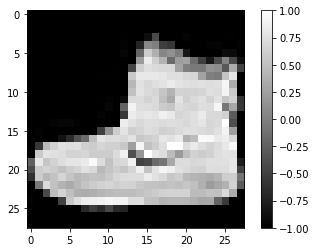

In [10]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

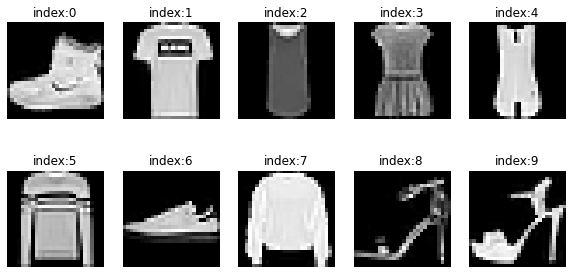

In [11]:
# 10개 추출
plt.figure(figsize = (10,5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28,28), cmap='gray')
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show()

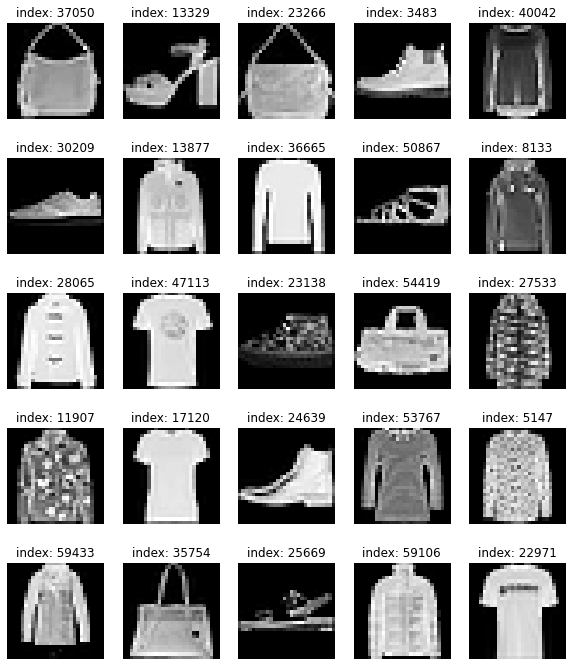

In [12]:
# 25개 임의추출
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 자료를 섞고, 이를 배치 사이즈에 따라 나누는 코드
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)p

## DCGAN

### 생성자 구현
- 자기가 생성한 fake image를 판별자가 진짜라고 판단하도록 속이고 싶어한다.

In [15]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))     # 입력값으로 (batch size, 100) 형상의 노이즈 벡터를 받음
    model.add(layers.BatchNormalization())                                    # Denase layer를 거치며 (batch size, 12544) 형상이 됨
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))                                      # Reshape을 통해 12544를 다시 (7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())      # 가중치가 폭발하지 않도록 정규화
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # 데이터셋을 -1~1 이내의 값으로 정규화했었으므로 동일하게 하기 위해 tanh 사용
    
    return model

(7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)

In [16]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [17]:
noise = tf.random.normal([1,100])

In [18]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

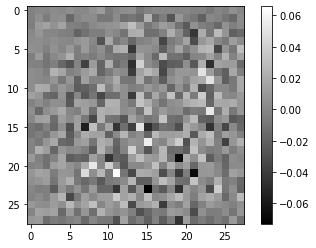

In [19]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

- -1과 1 사이에 적당히 잘 생성된 것을 확인할 수 있다. 아직은 학습하지 않은 상태여서 이런 노이즈 같은 이미지가 생성된 것이다.

### 판별자 구현
- 판별자는 생성자가 생성한 가짜/진짜 이미지를 가짜/진짜로 잘 판별하는 것이 목표이다.

In [23]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1))
    
    return model

(28, 28, 1) -> (14, 14, 64) -> (7, 7, 128)

In [24]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

아까 생성한 가짜 이미지를 판별자에 입력시켜 결과를 얻는 것이다.

In [25]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00256875]], dtype=float32)>

아직은 아무 의미가 없다.

## Loss function

- GAN은 loss function 으로 Cross Entropy 사용.
- 판별자는 이미지가 진짜인지 가짜인지 2개의 클래스 간 분류 문제이므로 Binary Cross Entropy 사용

In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

### generator loss

In [50]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator loss

In [51]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [52]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


# 위 함수를 뜯어보면   
# (1) tf.math.greater_equal(real_output, tf.constant([0.5])) : real_output의 각 원소가 0.5 이상인지 True, False 로 판별
# (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
# (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도 계산


## Optimizer

- Adam 최적화 기법을 활용해보자

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [54]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련 과정 설계

In [69]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) 입력 데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받는다.
- (2) 생성자 입력 노이즈 : generator가 Fake Image를 생성하기 위한 noise 를 images 한 세트와 같은 크기인 BATCH_SIZE만큼 생성한다.
- (3) tf.GradientTape() : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출럭
- (6) loss 계산
- (7) accuracy 계산
- (8) gradient 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 계산

In [70]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 시각화

In [71]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

tf.train.Checkpoint를 활용하여 코드 한 줄로 빠르게 버전 관리

In [72]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 시키기

위에서 우리는 한 단계를 학습하는 train_step, 샘플 이미지 생성 및 저장을 위한 generate_and_saave_images(), 학습 과정을 시각화하는 draw_train_history(), 모델 저장을 위한 checkpoint를 준비했다. 이제 이들을 합치면 된다.

In [73]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [74]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

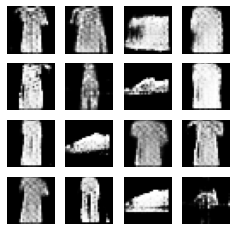

Time for training : 1445 sec


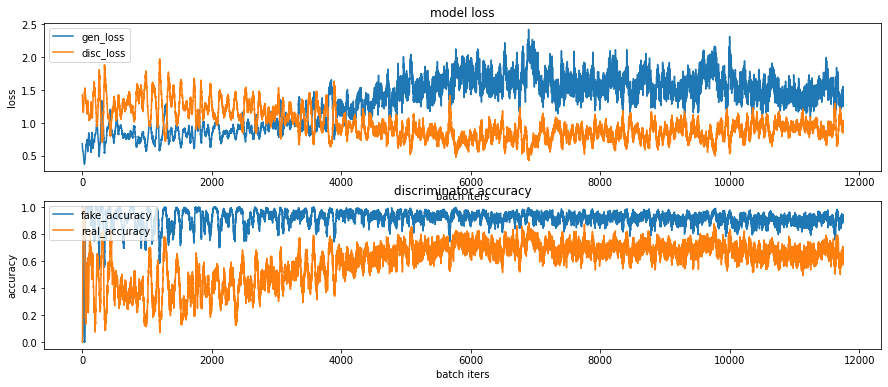

CPU times: user 8min 56s, sys: 27.7 s, total: 9min 24s
Wall time: 24min 6s


In [75]:
%%time
train(train_dataset, EPOCHS, save_every)

In [76]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1303512 Nov  9 06:07 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
